In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Simulating pore with varying tether length and sequences

In [2]:
'''
Initialise functions for plotting and processing data
'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video


#centre of barrel
xc = (60.57 + 39.43)/2
yc = 50
zc = 69.96
lengthToNm = 0.8518 
timeTons   = 3.03e-3
barHeight = 61.05

connShift = [0, 1134]


def getPoreNt(teth_len, numConn = 0):
    scaf_start = 0 + connShift[numConn]
    scaf_end   = 593-40 + teth_len*2 + connShift[numConn]
    return np.arange(teth_len + scaf_start, scaf_end - teth_len)
    
    
def getTopNt(teth_len, numConn = 0):
    #print(connShift[numConn])
    return teth_len + connShift[numConn]
    
def getMidNt(teth_len, numConn = 0):
    return teth_len + 44 + connShift[numConn]

def getBotNt(teth_len, numConn = 0):
    return teth_len + 89 + connShift[numConn]
    
    
def RMS(x, y, z):
    #takes a vector (e.g. velocity) broken into components x,y,z and returns the RMS value
    return np.sqrt(x**2 + y**2 + z**2)


def getPosition(data, nt, pos, vel, rot):
    #takes data and returns position in nm relative to centre of barrel
    xpos = data[:,0 + 3*nt*(pos + vel + rot)] 
    ypos = data[:,1 + 3*nt*(pos + vel + rot)] 
    zpos = data[:,2 + 3*nt*(pos + vel + rot)] 
    xpos = (xpos - xc)*lengthToNm
    ypos = (ypos - yc)*lengthToNm
    zpos = (zpos - zc)*lengthToNm
    return [xpos, ypos, zpos]

def getVelocity(data, nt, pos, vel, rot):
    #takes data and returns velocity in nm/ns relative to centre of barrel
    xvel = data[:,3 + 3*nt*(pos + vel + rot)] 
    yvel = data[:,4 + 3*nt*(pos + vel + rot)] 
    zvel = data[:,5 + 3*nt*(pos + vel + rot)] 
    xvel = xvel*lengthToNm/timeTons
    yvel = yvel*lengthToNm/timeTons
    zvel = zvel*lengthToNm/timeTons
    return [xvel, yvel, zvel]


def getAngularV(data, nt, pos, vel, rot):
    #takes data and returns angular velocity in 1/ns relative to centre of barrel
    xrot = data[:,6 + 3*nt*(pos + vel + rot)] 
    yrot = data[:,7 + 3*nt*(pos + vel + rot)] 
    zrot = data[:,8 + 3*nt*(pos + vel + rot)] 
    xrot = xrot/timeTons/np.pi*180
    yrot = yrot/timeTons/np.pi*180
    zrot = zrot/timeTons/np.pi*180
    return [xrot, yrot, zrot]


def takeMean(Vec):
    #given a list takes the mean along each coordinate
    for i in range(len(Vec)):
        Vec[i] = np.mean(Vec[i],1)
    return Vec


def takeMin(Vec):
    for i in range(len(Vec)):
        Vec[i] = np.array(Vec[i]).min(1)
    return Vec   
    
def takeMax(Vec):
    for i in range(len(Vec)):
        Vec[i] = np.array(Vec[i]).max(1)
    return Vec

def cartToCyl(x,y,z):
    #converts Cartesian coords to cylindrical coordinates in degrees
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan2(posV[1], posV[0])/np.pi*180
    return [r, theta, z]


def plotPositionHist(posV, pType = 'z', title = None, vline = None, saveName = None):
    '''
    plots the histogram of a spatial or angular coordinate
    posV is the position vector
    pType = 'x', 'y', 'z', 't' (theta), 'r' (radial)
    '''   
    plt.figure()
    plt.xlabel('Position (nm)')
    if pType == 'x':
        pos = posV[0]
        plt.title('Histogram of location of pore - x-position')
    elif pType == 'y':
        pos = posV[1]
        plt.title('Histogram of location of pore - y-position')        
    elif pType == 'z':
        pos = posV[2]
        plt.title('Histogram of location of pore - z-position')
    elif pType == 'r':
        pos = np.sqrt(posV[0]**2 + posV[1]**2)
        plt.title('Histogram of location of pore - r-position')
        plt.xlabel('Radial distance from centre of pore (nm)')
    elif pType == 't':
        pos = np.arctan2(posV[1], posV[0])/np.pi*180     
        plt.title('Histogram of location of pore - angular distance of pore in barrel')
        plt.xlabel('Angular distance of pore in barrel (degrees)')

    if title is not None:
        plt.title(title)
        
    plt.hist(pos, density = True, bins = int(np.sqrt(len(pos))))
    
    xmin, xmax, ymin, ymax = plt.axis()    
    if vline is not None:
        plt.vlines(vline, 0, ymax, 'r')
    plt.ylabel('Probability density')
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight')        
    plt.show()

    
    
def plotRMSHist(Vec, pType = 'vel', saveName = None):
    '''
    plots the histogram of a spatial or angular coordinate
    Vec is a vector: either position, velocity or angular velocity
    pType = 'pos', 'vel', 'rot'
    '''       
    RMSVec = RMS(Vec[0], Vec[1], Vec[2])
    plt.figure()
    plt.hist(RMSVec, density = True)
    plt.ylabel('Probability density')

    if pType == 'pos':
        plt.xlabel('Average root mean squared position (nm)')
        plt.title('Histogram of average root mean squared position')
    elif pType == 'vel':
        plt.xlabel('Average root mean squared velocity (nm/ns)')
        plt.title('Histogram of average root mean squared velocity')
    elif pType == 'rot':
        plt.xlabel('Average root mean squared angular velocity (degrees/ns)')
        plt.title('Histogram of average root mean squared angular velocity')
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight')    
    plt.show()



def plotMeanStdPair(xval, Means, Stds, ylabel1 = '', ylabel2 = '', xlabel = 'Tether length (bp)', title = '', saveName = None):
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color='b')
    ax1.plot(xval, Means, 'bo')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel(ylabel2, color='r')  
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.plot(xval, Stds, 'rx')
    plt.title(title)
    fig.tight_layout() 
    if saveName is not None:
        plt.savefig(saveName + '.png', bbox_inches='tight') 
    plt.show()
        
    
#plot mean-standard deviation pair with error bars
def plotMeanStdEB(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[1]):
            plt.errorbar(xval, Means[:,i], Stds[:,i], fmt=shapes[i] + ':', label = legend[i])
    
    if hline is not None:
        plt.hlines(hline, xval[0], xval[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()    

    
#plot mean-standard deviation pair with error bars inverse
def plotMeanStdEBInverse(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[0]):
            plt.errorbar(legend, Means[i,:], Stds[i,:], fmt=shapes[i] + ':', label = xval[i])
    
    if hline is not None:
        plt.hlines(hline, legend[0], legend[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()        

In [7]:
'''
Loop over data
'''

N = 4
M = 20

poreEnd = 43
topEnd  = 9
s = -100

ave_z   = np.zeros([N,M])
ave_r   = np.zeros([N,M])
ave_th  = np.zeros([N,M])
std_z   = np.zeros([N,M])
std_r   = np.zeros([N,M])
std_th  = np.zeros([N,M])

ave_top_z   = np.zeros([N,M])
ave_top_r   = np.zeros([N,M])
ave_top_th  = np.zeros([N,M])
std_top_z   = np.zeros([N,M])
std_top_r   = np.zeros([N,M])
std_top_th  = np.zeros([N,M])

ave_mid_z   = np.zeros([N,M])
ave_mid_r   = np.zeros([N,M])
ave_mid_th  = np.zeros([N,M])
std_mid_z   = np.zeros([N,M])
std_mid_r   = np.zeros([N,M])
std_mid_th  = np.zeros([N,M])

ave_bot_z   = np.zeros([N,M])
ave_bot_r   = np.zeros([N,M])
ave_bot_th  = np.zeros([N,M])
std_bot_z   = np.zeros([N,M])
std_bot_r   = np.zeros([N,M])
std_bot_th  = np.zeros([N,M])

ave_min_z   = np.zeros([N,M])
ave_min_r   = np.zeros([N,M])
ave_min_th  = np.zeros([N,M])
std_min_z   = np.zeros([N,M])
std_min_r   = np.zeros([N,M])
std_min_th  = np.zeros([N,M])

ave_max_z   = np.zeros([N,M])
ave_max_r   = np.zeros([N,M])
ave_max_th  = np.zeros([N,M])
std_max_z   = np.zeros([N,M])
std_max_r   = np.zeros([N,M])
std_max_th  = np.zeros([N,M])


ave_bonds   = np.zeros([N,M])
std_bonds   = np.zeros([N,M])
max_bonds   = np.zeros([N,M])
min_bonds   = np.zeros([N,M])
end_bonds   = np.zeros([N,M])

FracOut = np.zeros([N, M])
FracTop = np.zeros([N, M])

minBonds = 0 #[495, 495 + 60, 495 + 11*15, 495 + 84*2, 495 + 84*2] #84*2 is the cinch length

teth_len = 120
conns = [1,1,1,1]

for c in range(N):
    for m in range(M):
        print('Now processing : MD' + str(c) + ', seed: ' + str(m))
        data = np.genfromtxt('MD' + str(c) + '/outposMD' + str(m) + '.dat')

        #nucleotide to track
        nt = getPoreNt(teth_len, numConn = conns[c])

        #Get mean positions
        posV = takeMean(getPosition(data, nt, 1, 0, 0))

        #if pore is in opposite orientation
        if np.mean(posV[2]) > 0:
            zsign = 1
        else:
            zsign = 1

        ave_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_z[c,m]   = np.std(posV[2][s:-1])
        std_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get top positions
        posV = getPosition(data, getTopNt(teth_len, numConn = conns[c]), 1, 0, 0)
        ave_top_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_top_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_top_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_top_z[c,m]   = np.std(posV[2][s:-1])
        std_top_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_top_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get middle positions
        posV = getPosition(data, getMidNt(teth_len, numConn = conns[c]), 1, 0, 0)              
        ave_mid_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_mid_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_mid_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_mid_z[c,m]   = np.std(posV[2][s:-1])
        std_mid_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_mid_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get bottom positions
        posV = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)              
        ave_bot_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_bot_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_bot_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_bot_z[c,m]   = np.std(posV[2][s:-1])
        std_bot_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_bot_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))


        #Get minimum positions
        posV = takeMin(getPosition(data, nt, 1, 0, 0))  
        posV1 = posV.copy()
        ave_min_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_min_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_min_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_min_z[c,m]   = np.std(posV[2][s:-1])
        std_min_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_min_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        
        #Get maximum positions
        posV = takeMax(getPosition(data, nt, 1, 0, 0))            
        ave_max_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_max_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_max_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_max_z[c,m]   = np.std(posV[2][s:-1])
        std_max_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_max_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #fraction of time outside the pore
        FracOut[c,m] = sum(((posV1[2][s:-1][i] < -poreEnd) | (posV[2][s:-1][i] >  topEnd))  for i in range(len(posV[2][s:-1])))/len(posV[2][s:-1])      
        FracTop[c,m] = sum(((posV[2][s:-1][i] >  poreEnd)  | (posV1[2][s:-1][i] < -topEnd))  for i in range(len(posV[2][s:-1])))/len(posV[2][s:-1])

        #number of bonds
        bonds = np.genfromtxt('MD' + str(c) + '/numbondsMD' + str(m) + '.txt')    
        bonds = bonds - minBonds
        bonds = bonds.clip(min=0)
        ave_bonds[c,m]   = np.mean(bonds)
        std_bonds[c,m]   = np.std(bonds)
        max_bonds[c,m]   = np.max(bonds)
        min_bonds[c,m]   = np.min(bonds)        
        end_bonds[c,m]   = bonds[-1]
    

        
print('Finished processing')

Now processing : MD0, seed: 0
Now processing : MD0, seed: 1
Now processing : MD0, seed: 2
Now processing : MD0, seed: 3
Now processing : MD0, seed: 4
Now processing : MD0, seed: 5
Now processing : MD0, seed: 6
Now processing : MD0, seed: 7
Now processing : MD0, seed: 8
Now processing : MD0, seed: 9
Now processing : MD0, seed: 10
Now processing : MD0, seed: 11
Now processing : MD0, seed: 12
Now processing : MD0, seed: 13
Now processing : MD0, seed: 14
Now processing : MD0, seed: 15
Now processing : MD0, seed: 16
Now processing : MD0, seed: 17
Now processing : MD0, seed: 18
Now processing : MD0, seed: 19
Now processing : MD1, seed: 0
Now processing : MD1, seed: 1
Now processing : MD1, seed: 2
Now processing : MD1, seed: 3
Now processing : MD1, seed: 4
Now processing : MD1, seed: 5
Now processing : MD1, seed: 6
Now processing : MD1, seed: 7
Now processing : MD1, seed: 8
Now processing : MD1, seed: 9
Now processing : MD1, seed: 10
Now processing : MD1, seed: 11
Now processing : MD1, seed: 

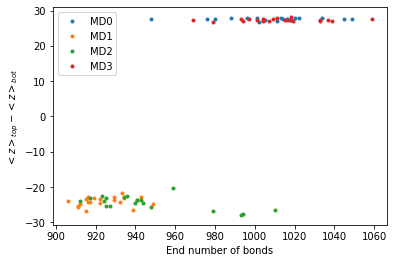

In [57]:
plt.figure()
plt.plot(end_bonds.transpose(), ave_top_z.transpose() - ave_bot_z.transpose(), '.')
plt.legend(['MD0','MD1','MD2','MD3'])
plt.ylabel(r'$<z>_{top} - <z>_{bot}$')
plt.xlabel('End number of bonds')
plt.show()

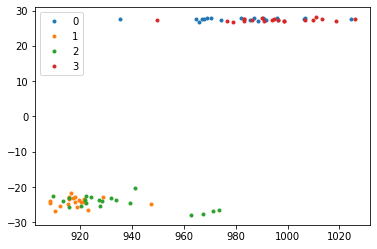

In [4]:
plt.plot(ave_bonds.transpose(), ave_top_z.transpose() - ave_bot_z.transpose(), '.')
plt.legend([0,1,2,3])
plt.show()

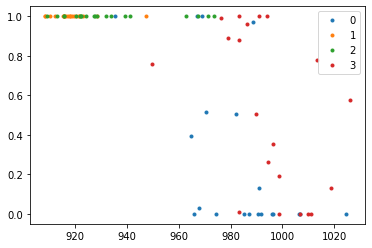

In [5]:
plt.plot(ave_bonds.transpose(), FracOut.transpose(), '.')
plt.legend([0,1,2,3])
plt.show()

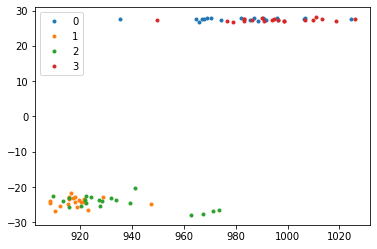

In [6]:
plt.plot(ave_bonds.transpose(), ave_top_z.transpose() - ave_bot_z.transpose(), '.')
plt.legend([0,1,2,3])
plt.show()

In [35]:
# Facing downwards, at completion

inc = ((ave_top_z.transpose() - ave_bot_z.transpose() > 0) & (end_bonds.transpose() > np.array([1118, 1063, 1063, 1118]))).transpose()

def mymean(x, i):
    return (np.sum(x*inc, 1)/np.sum(inc, 1))[i]

for i in range(4):
    if np.sum(inc[i]) > 0:
        print(mymean(FracOut,i), ',', mymean(ave_top_z,i), ',',  mymean(std_top_z,i), ',', mymean(ave_top_r,i),',', mymean(std_top_r,i),',',mymean(ave_mid_z,i),',', mymean(std_mid_z,i),',',mymean(ave_mid_r,i),',',mymean(std_mid_r,i),',',mymean(ave_bot_z,i),',', mymean(std_bot_z,i),',',mymean(ave_bot_r,i),',',mymean(std_bot_r,i),',',mymean(ave_min_z,i),',',mymean(std_min_z,i),',', mymean(ave_min_r,i),',',mymean(std_min_r,i),',',mymean(ave_max_z,i),',',mymean(std_max_z,i),',',mymean(ave_max_r,i),',',mymean(std_max_r,i),',',mymean(ave_bonds,i),',',mymean(std_bonds,i),',',np.min(min_bonds[:,inc[i]]),',',np.max(max_bonds[:,inc[i]]), ',', np.sum(inc[i]))
    else:
        print('No sims in this category')

No sims in this category
No sims in this category
No sims in this category
No sims in this category


In [44]:
# Facing downwards, not quite at completion

dx = 100
inc = ((ave_top_z.transpose() - ave_bot_z.transpose() > 0) & (end_bonds.transpose() > (np.array([1118, 1063, 1063, 1118]) - dx))).transpose()

def mymean(x, i):
    return (np.sum(x*inc, 1)/np.sum(inc, 1))[i]

for i in range(4):
    if np.sum(inc[i]) > 0:
        print(mymean(FracOut,i), ',', mymean(ave_top_z,i), ',',  mymean(std_top_z,i), ',', mymean(ave_top_r,i),',', mymean(std_top_r,i),',',mymean(ave_mid_z,i),',', mymean(std_mid_z,i),',',mymean(ave_mid_r,i),',',mymean(std_mid_r,i),',',mymean(ave_bot_z,i),',', mymean(std_bot_z,i),',',mymean(ave_bot_r,i),',',mymean(std_bot_r,i),',',mymean(ave_min_z,i),',',mymean(std_min_z,i),',', mymean(ave_min_r,i),',',mymean(std_min_r,i),',',mymean(ave_max_z,i),',',mymean(std_max_z,i),',',mymean(ave_max_r,i),',',mymean(std_max_r,i),',',mymean(ave_bonds,i),',',mymean(std_bonds,i),',',np.min(min_bonds[:,inc[i]]),',',np.max(max_bonds[:,inc[i]]), ',', np.sum(inc[i]))
    else:
        print('No sims in this category')

0.0 , -10.421932392331792 , 0.767289693179926 , 3.1823007085352084 , 1.1005690957174523 , -24.581835512768883 , 0.7040796808948155 , 3.30599489907251 , 0.8669342788241827 , -38.16163143310736 , 0.937326192949007 , 4.755585986531218 , 1.4616611283169179 , -38.96983658215895 , 0.7197434976203426 , 7.678395545469394 , 1.0291483391154248 , -8.751323106007384 , 0.7338361086472972 , 7.6061911441320635 , 0.9346504971754948 , 1004.0784298076808 , 32.07393749958095 , 852.0 , 1066.0 , 5
No sims in this category
No sims in this category
0.3434343434343434 , -14.267535816791101 , 0.8335381681904059 , 4.9991108640454796 , 0.8924147589627727 , -28.004612964722842 , 0.7526971305018835 , 2.207315867817966 , 0.7193990948960045 , -41.45731625139306 , 1.06753453392302 , 3.466624723238784 , 1.582737068447723 , -42.137036291612226 , 0.7946679441337076 , 7.222792811064743 , 1.0905982732234294 , -11.921288137295422 , 0.6943473086787669 , 9.171903333342152 , 1.0050112492080068 , 1006.7068423890474 , 33.970180

<ipython-input-44-fb33fa522f79>:7: RuntimeWarning: invalid value encountered in true_divide
  return (np.sum(x*inc, 1)/np.sum(inc, 1))[i]


In [30]:
# Facing upwards

inc = (ave_top_z.transpose() - ave_bot_z.transpose() < 0).transpose()

def mymean(x, i):
    return (np.sum(x*inc, 1)/np.sum(inc, 1))[i]

for i in range(4):
    if np.sum(inc[i]) > 0:
        print(mymean(FracOut,i), ',', mymean(ave_top_z,i), ',',  mymean(std_top_z,i), ',', mymean(ave_top_r,i),',', mymean(std_top_r,i),',',mymean(ave_mid_z,i),',', mymean(std_mid_z,i),',',mymean(ave_mid_r,i),',',mymean(std_mid_r,i),',',mymean(ave_bot_z,i),',', mymean(std_bot_z,i),',',mymean(ave_bot_r,i),',',mymean(std_bot_r,i),',',mymean(ave_min_z,i),',',mymean(std_min_z,i),',', mymean(ave_min_r,i),',',mymean(std_min_r,i),',',mymean(ave_max_z,i),',',mymean(std_max_z,i),',',mymean(ave_max_r,i),',',mymean(std_max_r,i),',',mymean(ave_bonds,i),',',mymean(std_bonds,i),',',np.min(min_bonds[:,inc[i]]),',',np.max(max_bonds[:,inc[i]]), ',', np.sum(inc[i]))
    else:
        print('No sims in this category')

No sims in this category
1.0 , 3.5688173359777573 , 1.9334694403861004 , 3.3157580337274517 , 1.3905354528824847 , 16.14760939664462 , 1.9890962904596186 , 5.8800177137332685 , 2.4990686744322246 , 27.66981930703439 , 3.151925860322077 , 11.905687844575644 , 4.795680677526587 , 1.2658688583173379 , 1.8078743761609997 , 10.65075912024196 , 4.256448678207837 , 29.09473885956634 , 2.7279006126541026 , 12.358987935385485 , 4.873268039811944 , 918.5996044212092 , 10.94994921102095 , 852.0 , 1066.0 , 20
1.0 , 0.060136556466355275 , 1.5167026185764423 , 3.385868828394792 , 1.2720181086854265 , 12.776756069597743 , 1.4428236728304191 , 5.006878902394466 , 2.008384046720791 , 24.42348340845897 , 2.4569918048209662 , 10.835531101279713 , 3.990485864420845 , -1.9278406196604077 , 1.4660827019505849 , 9.701180151505891 , 2.9086615326586465 , 26.140247811428708 , 1.980964739278086 , 12.629637340486498 , 3.6491274389241894 , 933.4226710948562 , 15.055156431009578 , 852.0 , 1066.0 , 20
No sims in thi

<ipython-input-30-aa881b4a660d>:6: RuntimeWarning: invalid value encountered in true_divide
  return (np.sum(x*inc, 1)/np.sum(inc, 1))[i]


In [32]:
# All simulations
for i in range(4):
    print(np.mean(FracOut[i]), ',', np.mean(ave_top_z[i]), ',',  np.mean(std_top_z[i]), ',', np.mean(ave_top_r[i]),',', np.mean(std_top_r[i]),',',np.mean(ave_mid_z[i]),',', np.mean(std_mid_z[i]),',',np.mean(ave_mid_r[i]),',',np.mean(std_mid_r[i]),',',np.mean(ave_bot_z[i]),',', np.mean(std_bot_z[i]),',',np.mean(ave_bot_r[i]),',',np.mean(std_bot_r[i]),',',np.mean(ave_min_z[i]),',',np.mean(std_min_z[i]),',', np.mean(ave_min_r[i]),',',np.mean(std_min_r[i]),',',np.mean(ave_max_z[i]),',',np.mean(std_max_z[i]),',',np.mean(ave_max_r[i]),',',np.mean(std_max_r[i]),',',np.mean(ave_bonds[i]),',',np.mean(std_bonds[i]),',',np.min(min_bonds[i]),',',np.max(max_bonds[i]))

0.2772727272727273 , -13.147897217442571 , 1.068873299313047 , 3.0890517449848574 , 1.1091040061297388 , -27.17460300674486 , 0.9983775057988222 , 3.2990077241075335 , 0.9294606783230455 , -40.7048539336689 , 1.1765558989262401 , 4.40450424447017 , 1.6640900193350234 , -41.44511702259152 , 1.0203376384537306 , 7.09841339517632 , 1.243756597822431 , -11.146912056700966 , 1.0402700636487887 , 8.088545227329794 , 1.019428355860425 , 982.997884455525 , 28.87340314428913 , 861.0 , 1066.0
1.0 , 3.5688173359777573 , 1.9334694403861004 , 3.3157580337274517 , 1.3905354528824847 , 16.14760939664462 , 1.9890962904596186 , 5.8800177137332685 , 2.4990686744322246 , 27.66981930703439 , 3.151925860322077 , 11.905687844575644 , 4.795680677526587 , 1.2658688583173379 , 1.8078743761609997 , 10.65075912024196 , 4.256448678207837 , 29.09473885956634 , 2.7279006126541026 , 12.358987935385485 , 4.873268039811944 , 918.5996044212092 , 10.94994921102095 , 862.0 , 981.0
1.0 , 0.060136556466355275 , 1.516702618

In [26]:
dx = 20
((ave_top_z.transpose() - ave_bot_z.transpose() > 0) & (end_bonds.transpose() > (np.array([1118, 1063, 1063, 1118]) - dx))).transpose()

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False]])

In [19]:
(np.array([1118, 1063, 1063, 1118]) - dx)

array([1018,  963,  963, 1018])

In [46]:
bondTS = []
av_bTS = []
mx_bTS = []
mn_bTS = []
sd_bTS = []

endTime = 1e15
for i in range(N):
    bonds = []
    for j in range(M):
        bonds.append(np.genfromtxt('MD' + str(i) + '/numbondsMD' + str(j) + '.txt'))
        if len(bonds[j]) < endTime:
            endTime = len(bonds[j])
    bondTS.append(bonds)

for i in range(N):
    bonds = []
    mxbnd = []
    mnbnd = []
    sdbnd = []
    
    for t in range(endTime):
        tmp = []
        for j in range(M):
            tmp.append(bondTS[i][j][t])
        bonds.append(np.sum(tmp)/M)
        mxbnd.append(np.max(tmp))
        mnbnd.append(np.min(tmp))
        sdbnd.append(np.std(tmp))        
    av_bTS.append(bonds)
    mx_bTS.append(mxbnd)
    mn_bTS.append(mnbnd)
    sd_bTS.append(sdbnd)
    

Text(0, 0.5, 'Average number of bonds')

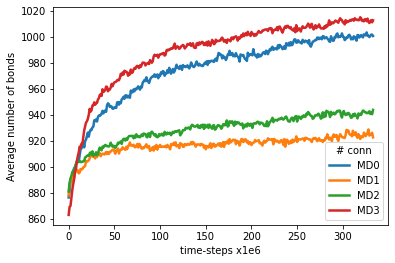

In [52]:
bonds = []
plt.figure()
for i in range(4):
    plt.plot(time, av_bTS[i], color = col[i], lw = 2.5, label = 'MD' + str(i))

plt.legend(title = '# conn')
plt.xlabel('time-steps x1e6')
plt.ylabel('Average number of bonds')


Text(0, 0.5, 'Average number of bonds')

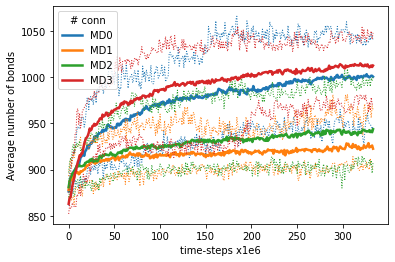

In [50]:
initTime = 0
time = np.arange(endTime)
time += initTime
bonds = []
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
plt.figure()
for i in range(4):
    plt.plot(time, av_bTS[i], color = col[i], lw = 2.5, label = 'MD' + str(i))
    plt.plot(time, mx_bTS[i], ':', color = col[i], lw = 1, label = None)
    plt.plot(time, mn_bTS[i], ':', color = col[i], lw = 1, label = None)
    
plt.legend(title = '# conn')
plt.xlabel('time-steps x1e6')
plt.ylabel('Average number of bonds')


ValueError: shape mismatch: objects cannot be broadcast to a single shape

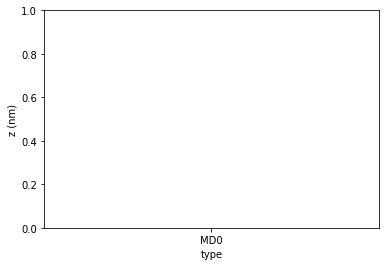

In [15]:
'''
Comparison between the different pores
'''

teth_lens = [teth_len]
seqNames = ['MD0', 'MD1', 'MD2', 'MD3']
types = ['top', 'mid', 'bot', 'mean', 'min']
ave_zs    = np.array([ave_top_z[:], ave_mid_z[:], ave_bot_z[:], ave_z[:], ave_min_z[:]])
std_zs    = np.array([std_top_z[:], std_mid_z[:], std_bot_z[:], std_z[:], std_min_z[:]])
ave_rs    = np.array([ave_top_r[:], ave_mid_r[:], ave_bot_r[:], ave_r[:], ave_min_r[:]])
std_rs    = np.array([std_top_r[:], std_mid_r[:], std_bot_r[:], std_r[:], std_min_r[:]])

plotMeanStdEBInverse(types, ave_zs, std_zs, ylabel = 'z (nm)', title = 'Vertical position in barrel', legend = seqNames, xlabel = 'type', hline = -32)
plotMeanStdEBInverse(types, ave_rs, std_rs, ylabel = 'r (nm)', title = 'Radial position in barrel', legend = seqNames, xlabel = 'type')
plotMeanStdEBInverse(types, std_zs, std_zs*0, ylabel = 'std(z) (nm)', title = 'Std Vertical position in barrel', legend = seqNames, xlabel = 'type')
plotMeanStdEBInverse(types, std_rs, std_rs*0, ylabel = 'std(r) (nm)', title = 'Std Radial position in barrel', legend = seqNames, xlabel = 'type')

plt.figure()
plt.plot(seqNames, FracOut, 'o:')
plt.ylabel('Outside barrel (%)')
plt.title('Fraction of time outside barrel')
plt.show()
#plotMeanStdEBInverse(teth_lens, 100*FracOut, 0*FracOut, ylabel = 'Outside barrel (%)', title = 'Fraction of time outside barrel', legend = seqNames, xlabel = 'type')
#plotMeanStdEBInverse(teth_lens, ave_bonds, std_bonds, ylabel = 'Number of tether bonds', title = 'Bonding on tether', legend = seqNames, xlabel = 'type')

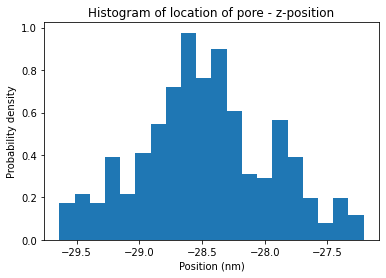

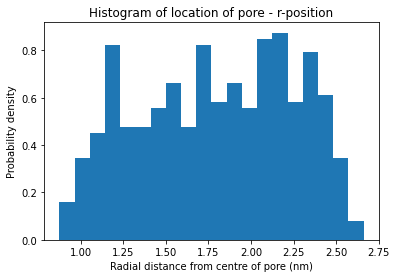

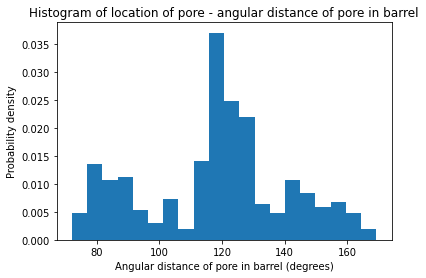

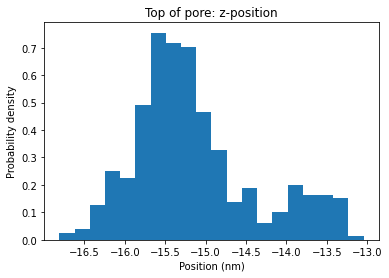

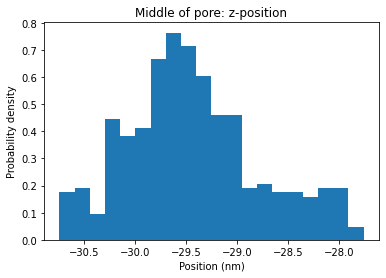

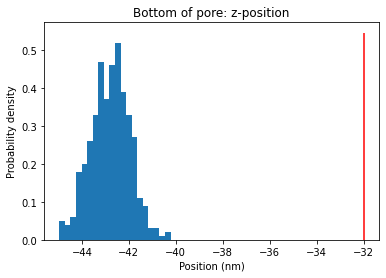

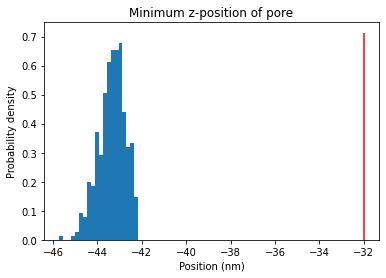

In [21]:
'''
Import data for tether length 45
'''

folder = 'MD1/'
data = np.genfromtxt(folder + '/jointpos.dat')

teth_len = 120

#nucleotide to track
nt = getPoreNt(teth_len,1)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 0, 0))

folder = folder + '/pics/'

#Plot histograms
plotPositionHist(posV, 'z', saveName = folder + 'zhist')
plotPositionHist(posV, 'r', saveName = folder + 'zhist')
plotPositionHist(posV, 't', saveName = folder + 'thethist')

#bottom, middle and top of pore
plotPositionHist(getPosition(data, getTopNt(teth_len,1), 1, 0, 0), 'z', title = 'Top of pore: z-position', saveName = folder + 'top_zhist')
plotPositionHist(getPosition(data, getMidNt(teth_len,1), 1, 0, 0), 'z', title = 'Middle of pore: z-position', saveName = folder + 'mid_zhist')
plotPositionHist(getPosition(data, getBotNt(teth_len,1), 1, 0, 0), 'z', title = 'Bottom of pore: z-position', vline = -32, saveName = folder + 'bot_zhist')
plotPositionHist(takeMin(getPosition(data, nt, 1, 0, 0)), 'z', title = 'Minimum z-position of pore', vline = -32, saveName = folder + 'min_zhist')